In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random

import matplotlib.pyplot as plt
import time

from model import ConvNet

from fasttext.CustomDataset import get_dataset
from fasttext.CustomDataset import vec_trans

[nltk_data] Downloading package punkt to /nfs4/ushashi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
random.seed(20)
np.random.seed(20)


NUM_MAPS = 4*60*6

LOG_SOFTMAX_VALUES = False

dset = get_dataset('data/test.csv')

FILE = 'fasttext/weights_2/Model_quicksave5.pt'

print('''
0 - World
1 - Sports
2 - Business
3 - Sci/Tech
''')

rand_files = random.sample(range(len(dset)), NUM_MAPS)


0 - World
1 - Sports
2 - Business
3 - Sci/Tech



In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

model = ConvNet(LOG_SOFTMAX_VALUES, WINDOW=3)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on',device)
print('Building model..')
model.to(device)
print('Model Built.')

model.load_state_dict(torch.load(FILE,map_location='cuda:0'))#,map_location='cuda:0'))
model.eval()


print('Printing Parameters')
for name, param in model.named_parameters():
    param.requires_grad = False
    print(name)

print('---Printing Parameters Finished!---')

Running on cuda:0
Building model..
Model Built.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
---Printing Parameters Finished!---


In [4]:
def comp_loss(mod, org, h, mode):
    '''
    Computes Loss Function
    '''
    
    
    ### Loss 1
    if mode == 1:
        z = torch.mean((mod[:,h]-org[:,h])**2)
    
    
    
    ### Loss 2
    if mode == 2:
        z = torch.mean((mod[:,:]-org[:,:])**2)
    
    ### Loss 3
    if mode == 3:
        z = mod-org
        z[:,h] = F.relu(org[:,h]-mod[:,h])
        z = torch.mean((F.relu(z))**2)
    
    ### Loss 4
    if mode == 4:
        z = mod-org
        z[:,h] = org[:,h]-mod[:,h]
        z = torch.mean(z)
    
    
    return z

In [5]:
from matplotlib import cm, transforms

def plot_text_heatmap(words, scores, norm=0, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    
    fig = plt.figure(figsize=(width, height))
    ax = plt.gca()
    ax.set_title(title, loc='left')
    tokens = words
    
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    if norm == 0:
        normalized_scores =  scores #/ np.max(np.abs(scores))
    elif norm == 1:
        normalized_scores =  0.5*scores/np.max(np.abs(scores)) + 0.5
    elif norm == 2:
        normalized_scores =  0.5*(scores/np.max(np.abs(scores))) + 0.5
        
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')


In [6]:
with open('prepositions.txt','r') as f:
    prep = [p.strip() for p in f]
    
print(prep)

['aboard', 'about', 'above', 'across', 'after', 'against', 'along', 'amid', 'among', 'anti', 'around', 'as', 'at', 'before', 'behind', 'below', 'beneath', 'beside', 'besides', 'between', 'beyond', 'but', 'by', 'despite', 'down', 'during', 'except', 'for', 'from', 'in', 'inside', 'into', 'like', 'near', 'of', 'off', 'on', 'onto', 'outside', 'over', 'past', 'per', 'regarding', 'save', 'since', 'than', 'through', 'to', 'toward', 'under', 'underneath', 'unlike', 'until', 'up', 'upon', 'via', 'with', 'within', 'without', 'is', 'was', 'a', 'an', 'the']


In [7]:
def GenRelMap_GreedyOpt(x, indices, num=12):
    
    x_input = torch.as_tensor(x).to(device, dtype = torch.float)
    x_out = model(x_input.clone()).detach()
    target = int(np.argmax(x_out.cpu().numpy(), axis=1))
    #print(target)
    
    order = [None]*num
    
    s = np.ones((64,1,x.shape[2],300))
    s = torch.as_tensor(s.astype(np.float32)).to(device)
    s.requires_grad = False
    
    n = vec_trans.matrixify('a',1)
    n = np.tile(n,(64,1,x.shape[2],1))
    for i in range(64):
        n[i] = np.tile(vec_trans.matrixify(prep[i],1),(1,1,x.shape[2],1))
    n = torch.as_tensor(n.astype(np.float32)).to(device)
    
    for i in range(num):
        min_arg = -1
        min_acc = float('inf')
        
        for arg in indices:
            if arg in order[:i]:
                continue
            
            s[:,:,arg,:] = torch.zeros((64,1,300))
            data_input = (x_input-n)*s+n
            out = model(data_input)
            acc = torch.mean(out,dim=0)[target].cpu().numpy()#1.0*sum(temp)/64.0
            if acc<min_acc:
                min_arg = arg
                min_acc = acc
            s[:,:,arg,:] = torch.ones((64,1,300))
        
        order[i] = min_arg
        s[:,:,min_arg,:] = torch.zeros((64,1,300))
            
    return order

In [8]:
def GenRelMap_LF(x, mode, num_iters=400, lr =8e-3, gam = 0.95, lamb=750):
    
    x_input = torch.as_tensor(x).to(device, dtype = torch.float)
    x_out = model(x_input.clone()).detach()
    highest_dim = int(np.argmax(x_out.cpu().numpy(), axis=1))
    
    if mode == 4:
        s = 0.5 + 0.1*np.random.rand(1,x.shape[2],1)
        s = torch.as_tensor(s.astype(np.float32)).to(device)
        s.requires_grad = True

        optimizer = optim.Adam([s], lr = lr)             # OR RAdam/DiffGrad/etc
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gam)

        n = vec_trans.matrixify('a',1)
        n = np.tile(n,(64,1,x.shape[2],1))    
        for i in range(64):
            n[i] = np.tile(vec_trans.matrixify(prep[i],1),(1,1,x.shape[2],1))
        n = torch.as_tensor(n.astype(np.float32)).to(device)

        for i in range(num_iters):
            data_input = (x_input-n)*s+n
            out = model(data_input)

            loss = 0.5*comp_loss(out, x_out, highest_dim, mode=4)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                s = s.clamp_(0,1) #- s
            scheduler.step()

        return s.detach().cpu().numpy()
    if mode ==2:
        dirr = 0
        inc = 1.0
        while True:
            s = 0.1*np.random.rand(1,x.shape[2],1)
            s = torch.as_tensor(s.astype(np.float32)).to(device)
            s = torch.autograd.Variable(s, requires_grad=True)

            optimizer = optim.Adam([s], lr = lr)             # OR RAdam/DiffGrad/etc
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gam)
            for i in range(num_iters):

                n = vec_trans.matrixify('a',1)
                n = np.tile(n,(64,1,x.shape[2],1))
                for i in range(64):
                    n[i] = np.tile(vec_trans.matrixify(prep[i],1),(1,1,x.shape[2],1))
                n = torch.as_tensor(n.astype(np.float32)).to(device)

                data_input = (x_input-n)*s+n
                out = model(data_input)

                loss = 0.5*comp_loss(out,x_out,highest_dim,2)+lamb*torch.mean(torch.abs(s))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                with torch.no_grad():
                    s += s.clamp_(0,1) - s
                scheduler.step()
            #print(s.detach().cpu().numpy().mean())
            if s.detach().cpu().numpy().mean()>0.18:
                if dirr<0:
                    inc = inc/2
                    #print('A')
                lamb = lamb*(1+inc)
                dirr = 1
                #print('1')
            elif s.detach().cpu().numpy().mean()<0.07:
                if dirr > 0:
                    inc = inc/2
                    #print('B')
                lamb = lamb/(1+inc)
                dirr = -1
                #print('-1')
            else:
                break
        return s.detach().cpu().numpy()

In [9]:
N_PC = 60

rmap_opt_l2 = [None]*4
rmap_opt_l4 = [None]*4
rmap_opt_no = [None]*4
wds = [None]*4
pths = [None]*4

for x in range(4):
    rmap_opt_l2[x] = [0]*N_PC
    rmap_opt_l4[x] = [0]*N_PC
    rmap_opt_no[x] = [0]*N_PC
    wds[x] = [0]*N_PC
    pths[x] = [0]*N_PC
    
counter = [0]*4
_ = 0
c_ = 0

while not all(x == N_PC for x in counter):
    
    x = dset[rand_files[_]]
    e = x['text']
    sample = x['matrix']
    target = int(x['class'])
    
    if len(e)<25 or len(e)>180:
        _ += 1
        continue
    
    sample = sample[None,None,:,:]
    
    x_input = torch.as_tensor(sample).to(device, dtype=torch.float)
    x_out = model(x_input.clone()).detach().cpu()
    
    _ += 1
    
    if int(np.argmax(x_out)) != target:    
        continue
        
    if counter[target] == N_PC:
        continue
    
    print(counter)
    c_ += 1
    
    ## Comb Opt
    ind = GenRelMap_GreedyOpt(sample, range(sample.shape[2]), num=10)
    rel = np.zeros(sample.shape[2])
    rel[ind] = range(1,11)[::-1]
    
    rmap_opt_no[target][counter[target]] = rel

    length = 20
    ## Opt Opt
    guider = GenRelMap_LF(sample, mode=2, num_iters=701, gam=0.995, lr = 8e-3)[0,:,0]
    z = np.argsort(guider)[::-1]
    ind = GenRelMap_GreedyOpt(sample, z[:length], num=10)
    rel = np.zeros(sample.shape[2])
    rel[ind] = range(1,11)[::-1]
    rmap_opt_l2[target][counter[target]] = rel
    
    guider = GenRelMap_LF(sample, mode=4, num_iters=701, gam=0.995, lr = 8e-3)[0,:,0]
    z = np.argsort(guider)[::-1]
    ind = GenRelMap_GreedyOpt(sample, z[:length], num=10)
    rel = np.zeros(sample.shape[2])
    rel[ind] = range(1,11)[::-1]
    rmap_opt_l4[target][counter[target]] = rel
    
    wds[target][counter[target]] = e
    pths[target][counter[target]] = rand_files[_]
    
    counter[target] += 1 
    
    if c_%10==0:
        print('##### At '+str(c_))
        np.save('relmap_data/data_greedy_'+str(c_)+'.npy',[rmap_opt_no,rmap_opt_l2,rmap_opt_l4,wds,pths])

[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 1, 0]
[1, 0, 2, 0]
[1, 1, 2, 0]
[1, 2, 2, 0]
[2, 2, 2, 0]
[2, 2, 2, 1]
[2, 3, 2, 1]
[2, 3, 2, 2]
##### At 10
[3, 3, 2, 2]
[4, 3, 2, 2]
[4, 3, 2, 3]
[5, 3, 2, 3]
[6, 3, 2, 3]
[6, 3, 2, 4]
[6, 4, 2, 4]
[6, 4, 3, 4]
[7, 4, 3, 4]
[7, 4, 3, 5]
##### At 20
[8, 4, 3, 5]
[8, 4, 3, 6]
[8, 4, 4, 6]
[9, 4, 4, 6]
[9, 4, 5, 6]
[9, 4, 5, 7]
[9, 4, 5, 8]
[9, 4, 5, 9]
[10, 4, 5, 9]
[10, 4, 6, 9]
##### At 30
[10, 4, 6, 10]
[11, 4, 6, 10]
[11, 4, 6, 11]
[11, 4, 6, 12]
[11, 4, 6, 13]
[11, 4, 6, 14]
[11, 5, 6, 14]
[11, 5, 6, 15]
[11, 5, 7, 15]
[11, 5, 7, 16]
##### At 40
[12, 5, 7, 16]
[12, 6, 7, 16]
[12, 7, 7, 16]
[12, 7, 8, 16]
[12, 7, 8, 17]
[13, 7, 8, 17]
[13, 7, 9, 17]
[13, 7, 9, 18]
[13, 8, 9, 18]
[13, 9, 9, 18]
##### At 50
[14, 9, 9, 18]
[15, 9, 9, 18]
[15, 10, 9, 18]
[15, 11, 9, 18]
[15, 12, 9, 18]
[15, 12, 9, 19]
[16, 12, 9, 19]
[16, 12, 9, 20]
[16, 12, 10, 20]
[17, 12, 10, 20]
##### At 60
[17, 12, 10, 21]
[17, 13, 10, 21]
[17, 13, 10, 22]
[18, 13, 10, 22]
[18, 13,

In [10]:
np.save('relmap_greedy.npy',[rmap_opt_no,rmap_opt_l2,rmap_opt_l4,wds,pths])

In [9]:
[rmap_opt_no,rmap_opt_l2,rmap_opt_l4,wds,pths] = np.load('relmap_greedy.npy',allow_pickle=True)

tensor([3.])


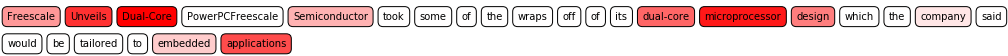

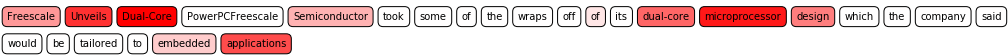

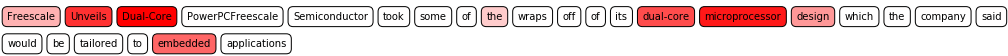

In [10]:
no = 12
cls = 3
#print(pths)
#rand_files.index(pths[cls][no])-1
#print(pths[cls][no])
print(dset[rand_files[rand_files.index(pths[cls][no])-1]]['class'])
x = wds[cls][no]

if len(x)>80:
    x = x[:80]
    
plot_text_heatmap(x,rmap_opt_no[cls][no],norm=1)
plot_text_heatmap(x,rmap_opt_l2[cls][no],norm=1)
plot_text_heatmap(x,rmap_opt_l4[cls][no],norm=1)

In [11]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

from keras import backend as K
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, GlobalMaxPool2D, Dropout
from keras.models import Model
import tensorflow as tf


print(K.image_data_format())

with tf.device('/GPU:0'):
    inp = Input((None,300,1))
    x = Conv2D(1024,(3,300),activation='relu', name='conv1')(inp)
    
    x = GlobalMaxPool2D('channels_last')(x)
    x = Dense(256,name='fc1',activation='relu')(x)
    z = Dropout(0.25)(x)
    ou = Dense(32,name='fc2',activation='relu')(z)
    ou = Dropout(0.3)(ou)
    out = Dense(4,name='fc3')(ou)
    outz = Dropout(0.2)(out)
    k_model = Model(inp, outz)


trained_weights = model.state_dict()

pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)
print(unique_layers)


for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

k_model.summary()

Using TensorFlow backend.
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/nfs4

channels_last
['conv1' 'fc1' 'fc2' 'fc3']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 300, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, 1, 1024)     922624    
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1024)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 32)                8224      
_________________________________________________________________
dropout_2 (Dropout)          (None

In [12]:
import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

In [13]:
rmin = float('+inf')
rmax = float('-inf')

for i in range(len(dset)):
    x = dset[i]['matrix']
    inf = torch.min(x)
    sup = torch.max(x)
    if inf< rmin:
        rmin = inf
        #print('A')
    if sup> rmax:
        #print('B')
        rmax = sup
        
print(rmin)
print(rmax)

tensor(-24.0467)
tensor(25.3291)


In [14]:
train_set = get_dataset('data/train.csv')

train_data = np.zeros((len(train_set),1,80,300))
for i in range(len(train_set)):
    train_data[i] = train_set[i]['matrix']

train_data = train_data.reshape((-1,80,300,1))
print(train_data.shape)

(120000, 80, 300, 1)


In [15]:
input_range = (-24.0467,25.3291)

analyzers = []


noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


methods = [
    # NAME                    OPT.PARAMS         
    ("gradient",              {},           "Gradient"),
    ("smoothgrad",            {"noise_scale": noise_scale,"postprocess": "square"},     "SmoothGrad"),
    ("deconvnet",             {},           "Deconvnet"),
    ("guided_backprop",       {},           "Guided Backprop",),
    ("pattern.net",           {"pattern_type": "relu"}, "PatternNet"),
    ("pattern.attribution",   {"pattern_type": "relu"}, "PatternAttribution"),
    ("deep_taylor.bounded",   {"low": input_range[0],"high": input_range[1]}, "DeepTaylor"),
    ("input_t_gradient",      {},          "Input * Gradient"),
    ("integrated_gradients",  {"reference_inputs": ri},   "Integrated Gradients"),
    #("deep_lift.wrapper",     {"reference_inputs": ri},    "DeepLIFT Wrapper - Rescale"),
    #("deep_lift.wrapper",     {"reference_inputs": ri, "nonlinear_mode": "reveal_cancel"}, "DeepLIFT Wrapper - RevealCancel"),
    ("lrp.z",                 {},   "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},    "LRP-Epsilon"),
]





for method in methods:
    #print(method)
    analyzer = innvestigate.create_analyzer(method[0], k_model,**method[1]) #neuron_selection_mode="index", 
    analyzer.fit(train_data, batch_size=1024, verbose=1)
    analyzers.append(analyzer)

/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/innvestigate/analyzer/base.py:130: RuntimeWarning: This analyzer does not need to be trained. Still fit() is called.
  " Still fit() is called.", RuntimeWarning)


Epoch 1/1
118/118 [==============================] - 30s 258ms/step - loss: 4.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000 - broadcast_3_loss: 1.0000 - broadcast_4_loss: 1.0000
Epoch 1/1
118/118 [==============================] - 31s 261ms/step - loss: 4.0000 - broadcast_5_loss: 1.0000 - broadcast_6_loss: 1.0000 - broadcast_7_loss: 1.0000 - broadcast_8_loss: 1.0000


In [14]:

'''

methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor']
kwargs = [{}, {}, {}, {}]

analyzers = []

for method,kl in zip(methods,kwargs):
    #print(method)
    analyzer = innvestigate.create_analyzer(method, k_model, **kl)
    #analyzer.fit(sample[None,:,:,None], batch_size=256, verbose=1)
    analyzers.append(analyzer)
'''

In [18]:
from keras.layers import Softmax
import time

test_sample_paths = [rand_files[rand_files.index(pths[1][41])-1]]

#test_sample_preds = [None]*len(test_sample_paths)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_paths), len(analyzers), 1, 80])

for i, ridx in enumerate(test_sample_paths):
    
    x = dset[ridx]['matrix']
    x = x.reshape((1, -1, 300,1))    
    x = x.numpy()
    prob = k_model.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    #test_sample_preds[i] = y_hat
    
    
    for aidx, analyzer in enumerate(analyzers):
        print(analyzer)
        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)        ### Add the values along the embedding dimension
        analysis[i, aidx] = a

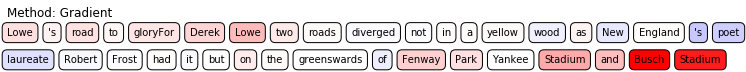

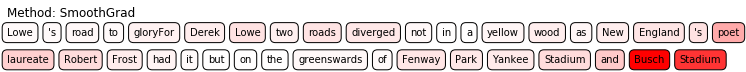

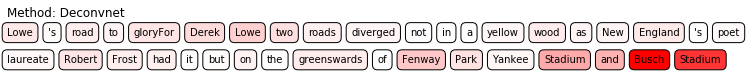

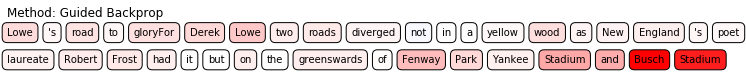

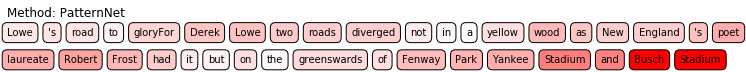

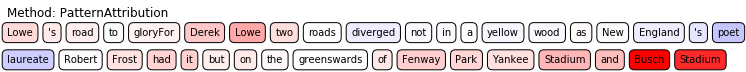

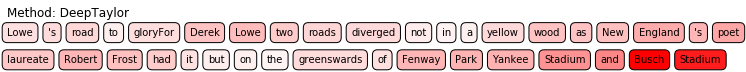

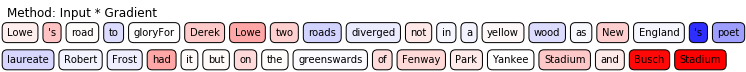

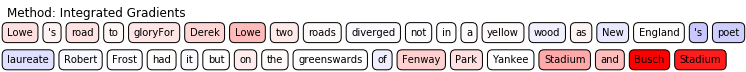

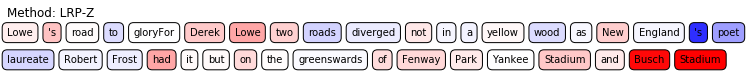

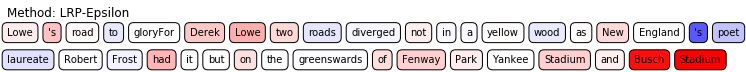

In [22]:
names = [method[2] for method in methods]
for i, idx in enumerate(test_sample_paths):
    words = dset[idx]['text']   
    for j, method in enumerate(methods):
        plot_text_heatmap(words, analysis[i, j].reshape(-1), norm=2, title='Method: %s' % names[j], verbose=0)
        plt.show()

In [23]:
x = dset[test_sample_paths[0]]['matrix']
x = x.reshape((1, -1, 300,1)).numpy() 
print(k_model.predict(x))
x = x.reshape((1, 1,-1, 300)) 
model(torch.as_tensor(x).to(device, dtype=torch.float))

[[ -4.1905622   6.9618554  -7.0119634 -10.172652 ]]


tensor([[ -4.1906,   6.9619,  -7.0120, -10.1727]], device='cuda:0')

In [24]:
test_sample_paths = []
for i in range(240):
    test_sample_paths.append(rand_files[rand_files.index(pths[i//60][i%60])-1])

#test_sample_preds = [None]*len(test_sample_paths)

analyzis = [[None]*len(analyzers)]*len(test_sample_paths)

for i, ridx in enumerate(test_sample_paths):
 
    x = dset[ridx]['matrix']
    x = x.reshape((1, -1, 300,1)).numpy()    
    analyzis[i] = [np.zeros(x.shape[1])]*len(analyzers)
    
    for aidx, analyzer in enumerate(analyzers):        
        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)
        analyzis[i][aidx] = a   

In [25]:
###### ACC GRAPH
def get_acc_batched(x,target,maps):
    BTCH = 64
    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(11)
        
        n = vec_trans.matrixify('a',1)
        n = np.tile(n,(64,1,x.shape[0],1))
        for it in range(64):
            n[it] = np.tile(vec_trans.matrixify(prep[it],1),(1,1,x.shape[0],1))
        #n = torch.as_tensor(n.astype(np.float32)).to(device)
        
        order = np.argsort(maps[i])[::-1]
        xt = x[None,None,:,:]
        xt = np.tile(xt,(BTCH,1,1,1))
        with torch.no_grad():
            for k in range(1,11):
                xt[:,0,order[:k],:] = n[:,0,order[:k],:] 
                out = model(torch.as_tensor(xt.astype(np.float32)).to(device))
                highest_dim = np.argmax(out.cpu().numpy(), axis=1)
                temp = [int(x==target) for x in highest_dim]
                yval[i][k] = sum(temp)/BTCH
            yval[i][0] = 1
    return yval

In [26]:
N_PC=60
y_acc=[[np.zeros(11)]*3]*240
y2_acc = [[np.zeros(11)]*len(analyzers)]*240
for i in range(60):
    for j in range(4):
        x = dset[rand_files[rand_files.index(pths[j][i])-1]]['matrix'].numpy()
        m1 = rmap_opt_no[j][i]
        m2 = rmap_opt_l2[j][i]
        m3 = rmap_opt_l4[j][i]
        y_acc[j*N_PC + i] = get_acc_batched(x,j,[m1,m2,m3])
        y2_acc[j*N_PC + i] = get_acc_batched(x,j,analyzis[j*N_PC+i])
    
    if i%10==0:
        print(i)

0
10
20
30
40
50


In [27]:
z = np.array(y_acc)
y1am = z.mean(axis=0)

z = np.array(y2_acc)
y2am = z.mean(axis=0)


Text(0, 0.5, 'Acc - Batched')

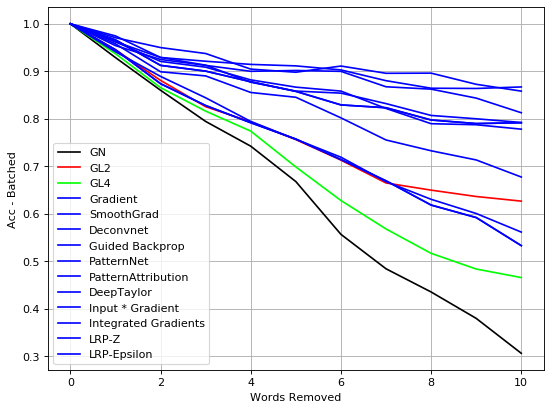

In [29]:
colors = ['#000000','#FF0000','#00FF00']+['#0000FF']*11 #,'#0000FF','#0000FF','#0000FF','#0000FF']
          #'#a8ddb5','#606060','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5']

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(y1am[0],colors[0])
plt.plot(y1am[1],colors[1])
plt.plot(y1am[2],colors[2])

for i in range(y2am.shape[0]):
    plt.plot(y2am[i],colors[3+i])
    
plt.legend(['GN','GL2','GL4']+names)
plt.grid(True)
plt.xlabel('Words Removed')
plt.ylabel('Acc - Batched')

In [30]:
###### ACC GRAPH
def get_acc_zero(x,target,maps):
    BTCH = 1

    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(11)
        
        n = np.zeros((BTCH,1,x.shape[0],300))
        order = np.argsort(maps[i])[::-1]
        xt = x[None,None,:,:]
        xt = np.tile(xt,(BTCH,1,1,1))
                
        with torch.no_grad():
            for k in range(1,11):
                xt[:,0,order[:k],:] = n[:,0,order[:k],:] 
                out = model(torch.as_tensor(xt.astype(np.float32)).to(device))
                highest_dim = np.argmax(out.cpu().numpy(), axis=1)
                temp = [int(x==target) for x in highest_dim]
                yval[i][k] = sum(temp)/BTCH
            yval[i][0] = 1
    return yval

In [31]:
y3_acc=[[np.zeros(11)]*3]*240
y4_acc = [[np.zeros(11)]*len(analyzers)]*240
for i in range(60):
    for j in range(4):
        x = dset[rand_files[rand_files.index(pths[j][i])-1]]['matrix'].numpy()
        m1 = rmap_opt_no[j][i]
        m2 = rmap_opt_l2[j][i]
        m3 = rmap_opt_l4[j][i]
        y3_acc[j*N_PC + i] = get_acc_zero(x,j,[m1,m2,m3])
        y4_acc[j*N_PC + i] = get_acc_zero(x,j,analyzis[j*N_PC+i])

In [32]:
z = np.array(y3_acc)
y3am = z.mean(axis=0)

z = np.array(y4_acc)
y4am = z.mean(axis=0)

Text(0, 0.5, 'Acc - Zero')

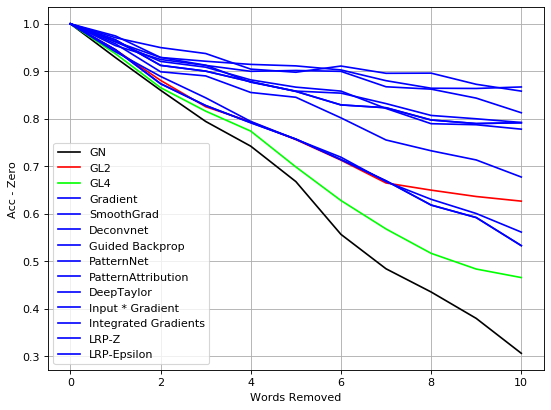

In [33]:
colors = ['#000000','#FF0000','#00FF00']+['#0000FF']*11 #,'#0000FF','#0000FF','#0000FF','#0000FF']
          #'#a8ddb5','#606060','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5']

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(y1am[0],colors[0])
plt.plot(y1am[1],colors[1])
plt.plot(y1am[2],colors[2])

for i in range(y2am.shape[0]):
    plt.plot(y2am[i],colors[3+i])
    
plt.legend(['GN','GL2','GL4']+names)
plt.grid(True)
plt.xlabel('Words Removed')
plt.ylabel('Acc - Zero')

In [34]:
print(y1am[2])
print(y3am[2])

[1.         0.93704427 0.8655599  0.81614583 0.77402344 0.69856771
 0.62786458 0.56790365 0.51653646 0.48346354 0.46549479]
[1.         0.93333333 0.86666667 0.825      0.775      0.71666667
 0.63333333 0.56666667 0.5125     0.475      0.45833333]
